In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

In [2]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

In [3]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [4]:
def apply_trading_system(dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

# Funzioni utilizzate:

In [43]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)

def profit1(operations):
    return round(operations.sum(),2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", round(100 - percent_win(operations),2))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    print("")
    print("Calmar Ratio:            ", my_calmar_ratio(trading_system.open_equity))
    print("Calmar Ratio Yearly:     ", my_calmar_ratio_yearly(operations,trading_system.open_equity)[0])
    print("Sharpe Ratio:            ", my_sharpe_ratio(trading_system.open_equity))
    print("Sharpe Ratio Yearly:     ", my_sharpe_ratio_yearly(operations)[0])   
    print("Kestner Ratio:           ", my_kestner_ratio(operations))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

In [6]:
def my_calmar_ratio(equity):
    """
    Il rapporto tra il guadagno finale e il max draw down registrato
    """
    netprofit = equity[-1]
    mdd = max_draw_down(equity)
    if mdd != 0:
        return round(netprofit / -mdd, 2)
    else:
        return np.inf
    
def my_calmar_ratio_yearly(operations,equity):
    """
    Il rapporto medio su base annuale tra
    il guadagno ed il draw down
    """
    yearly_operations = operations.resample('A').sum()
    yearly_drawdown = drawdown(equity).resample('A').min()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_drawdown[i] != 0:
            records.append(-yearly_operations[i] / yearly_drawdown[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    return round(records.mean(),2), records

def my_sharpe_ratio(equity):
    """
    Il rapporto tra il guadagno totale 
    e la deviazione standard dell'equity line
    """
    netprofit = equity[-1]
    std = equity.std()
    if std != 0:
        return round(netprofit / std,2)
    else:
        return np.inf

def my_sharpe_ratio_yearly(operations):
    """
    Il rapporto medio su base annuale tra
    il guadagno e la deviazione standard
    """
    yearly_operations = operations.resample('A').sum()
    yearly_std = operations.resample('A').std()
    records = []
    
    for i in range(len(yearly_operations)):
        if yearly_std[i] != 0:
            records.append(yearly_operations[i] / yearly_std[i])
        else:
            records.append(np.inf)
            
    records = pd.Series(records, index = yearly_operations.index)
    
    return round(records.mean(),2), records

def my_kestner_ratio(operations):
    """
    Kestner Ratio versione 2003
    Una volta calcolata l'equity line dei contributi mensili delle operazioni aggregate
    calcoliamo la retta di regressione che meglio approssima lo sciame di punti 
    e riportiamo il rapporto tra la pendenza di tale retta e l'errore standard
    tra ogni punto e la retta medesima
    """
    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('M').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),4)
    else:
        return np.inf

# Motore di Ottimizzazione

In [9]:
opt_simulation = []
opt_parameter1 = []
opt_parameter2 = []
opt_operations = []
opt_profit = []
opt_profit_factor = []
opt_avg_trade = []
opt_percent_win = []
opt_reward_risk_ratio = []
opt_max_draw_down = []
opt_avg_draw_down = []
opt_max_delay_between_peaks = []
opt_avg_delay_between_peaks = []
opt_calmar_ratio = []
opt_calmar_ratio_yearly = []
opt_sharpe_ratio = []
opt_sharpe_ratio_yearly = []
opt_kestner_ratio = []

data = load_data_daily("AAPL_Daily.txt")
dataset = data.copy()
    
COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "market"
enter_level = dataset.open

min_period_1 = 5
max_period_1 = 50
opt_step_1 = 5

min_period_2 = 5
max_period_2 = 50
opt_step_2 = 5

optimization_fitness = "kr"
# "profit": profit
# "pf": profit_factor
# "at": avg_trade
# "pw": percent_win
# "rrr": reward_risk_ratio
# "mdd": maxdrawdown
# "add": avg_draw_down
# "adbp": avg_delay_between_peaks
# "cr": calmar_ratio
# "cry": calmar_ratio_yearly
# "sr": sharpe_ratio
# "sry": sharpe_ratio_yearly
# "kr": kestner_ratio

start_time = datetime.datetime.now()
print("optimization Process startet at:",start_time)
print("")
opt_steps = int((max_period_1 - min_period_1) / opt_step_1 + 1) * int((max_period_2 - min_period_2) / opt_step_2 + 1)
print("Optimization Steps:", int((max_period_1 - min_period_1) / opt_step_1 + 1) * \
                             int((max_period_2 - min_period_2) / opt_step_2 + 1))
print("")
print("Optimizing...")
print("")

print("simulation","opt1","opt2","operations","profit","pf","at","pw","rrr","mdd","add",
      "mddp","adbp","cr","cry","sr","sry","kr")

simulation_number = 1
for opt1 in range(min_period_1, max_period_1 + opt_step_1, opt_step_1):
    for opt2 in range(min_period_2, max_period_2 + opt_step_2, opt_step_2):    
        
        #print("Optimization n.:", simulation_number, "opt:", opt1)

        dataset["hhv"] = dataset.high.rolling(opt1).max()
        dataset["llv"] = dataset.low.rolling(opt2).min()

        enter_rules = crossover(dataset.close,dataset.hhv.shift(1))
        exit_rules = crossunder(dataset.close,dataset.llv.shift(1)) | (dataset.day < dataset.day.shift(1))

        trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                              enter_level, enter_rules, exit_rules)
        operations = trading_system.operations.dropna()
        if operations.count() > 0:
            opt_simulation.append(simulation_number)
            opt_parameter1.append(opt1)
            opt_parameter2.append(opt2)
            opt_operations.append(operation_number(operations))
            opt_profit.append(profit(trading_system.open_equity))
            opt_profit_factor.append(profit_factor(operations))
            opt_avg_trade.append(avg_trade(operations))
            opt_percent_win.append(percent_win(operations))
            opt_reward_risk_ratio.append(reward_risk_ratio(operations))
            opt_max_draw_down.append(max_draw_down(trading_system.open_equity))
            opt_avg_draw_down.append(avgdrawdown_nozero(trading_system.open_equity))
            opt_max_delay_between_peaks.append(max_delay_between_peaks(trading_system.open_equity))
            opt_avg_delay_between_peaks.append(avg_delay_between_peaks(trading_system.open_equity))
            opt_calmar_ratio.append(my_calmar_ratio(trading_system.open_equity))
            opt_calmar_ratio_yearly.append(my_calmar_ratio_yearly(operations,trading_system.open_equity)[0])
            opt_sharpe_ratio.append(my_sharpe_ratio(trading_system.open_equity))
            opt_sharpe_ratio_yearly.append(my_sharpe_ratio_yearly(operations)[0])
            opt_kestner_ratio.append(my_kestner_ratio(operations))
            print(opt_simulation[-1],
                  opt1, 
                  opt2,
                  operation_number(operations), 
                  profit(trading_system.open_equity), 
                  profit_factor(operations),
                  avg_trade(operations),
                  percent_win(operations), 
                  reward_risk_ratio(operations),
                  max_draw_down(trading_system.open_equity),
                  avgdrawdown_nozero(trading_system.open_equity),
                  max_delay_between_peaks(trading_system.open_equity),
                  avg_delay_between_peaks(trading_system.open_equity),
                  my_calmar_ratio(trading_system.open_equity),
                  my_calmar_ratio_yearly(operations,trading_system.open_equity)[0], 
                  my_sharpe_ratio(trading_system.open_equity),
                  my_sharpe_ratio_yearly(operations)[0], 
                  my_kestner_ratio(operations)
                 )
        else: 
            print("Nessuna operazione registrata!")
            opt_parameter1.append(opt1)
            opt_parameter2.append(opt2)
            opt_operations.append(0)
            opt_profit.append(0)
            opt_profit_factor.append(0)
            opt_avg_trade.append(0)
            opt_percent_win.append(0)
            opt_reward_risk_ratio.append(0)
            opt_max_draw_down.append(0)
            opt_avg_draw_down.append(0)
            opt_max_delay_between_peaks.append(0)
            opt_avg_delay_between_peaks.append(0)
            opt_calmar_ratio.append(0)
            opt_calmar_ratio_yearly.append(0)
            opt_sharpe_ratio.append(0)
            opt_sharpe_ratio_yearly.append(0)
            opt_kestner_ratio.append(0)

        simulation_number += 1
    
print("")
end_time = datetime.datetime.now()
print("Optimization elaborated in:", end_time - start_time)

optimization Process startet at: 2019-12-02 18:30:04.809118

Optimization Steps: 100

Optimizing...

simulation opt1 opt2 operations profit pf at pw rrr mdd add mddp adbp cr cry sr sry kr
1 5 5 249 31939.43 1.68 128.27 50.6 1.64 -5266.16 -1317.74 901 45.54 6.07 1.09 3.32 2.66 0.2425
2 5 10 222 38437.0 1.84 173.14 55.86 1.46 -5572.44 -1349.69 690 36.55 6.9 1.24 3.2 3.12 0.2601
3 5 15 215 37400.59 1.8 173.96 58.14 1.3 -6408.94 -1541.53 707 35.94 5.84 1.21 3.16 3.05 0.2635
4 5 20 212 39217.65 1.87 184.99 59.43 1.28 -5794.37 -1369.49 694 34.91 6.77 1.3 3.11 3.14 0.2688
5 5 25 211 38262.99 1.84 181.34 59.24 1.26 -5513.47 -1359.59 690 36.56 6.94 1.15 3.05 3.05 0.251
6 5 30 209 36116.53 1.74 172.81 60.29 1.15 -8012.49 -1959.04 1113 36.69 4.51 1.19 2.83 3.05 0.2625
7 5 35 208 36792.78 1.77 176.89 60.58 1.15 -8012.49 -1948.67 1113 35.8 4.59 1.13 2.83 3.12 0.2808
8 5 40 206 36382.45 1.76 176.61 60.68 1.14 -8012.49 -2004.51 1156 36.73 4.54 1.08 2.81 3.16 0.2768
9 5 45 206 37179.74 1.79 180.48 60.

83 45 15 112 29673.96 2.84 264.95 67.86 1.35 -2796.88 -786.63 592 45.02 10.61 1.52 2.91 2.71 0.2883
84 45 20 112 30886.89 3.06 275.78 69.64 1.34 -2182.31 -699.16 566 42.66 14.15 1.58 2.91 2.84 0.2903
85 45 25 112 31819.93 3.27 284.11 69.64 1.42 -2236.36 -656.23 527 42.35 14.23 1.65 2.89 2.88 0.2823
86 45 30 112 31942.79 3.3 285.2 69.64 1.44 -2236.36 -651.08 527 41.93 14.28 1.65 2.89 2.88 0.2872
87 45 35 112 31793.78 3.26 283.87 69.64 1.42 -2236.36 -657.96 527 41.33 14.22 1.62 2.88 2.87 0.2863
88 45 40 112 31464.36 3.19 280.93 69.64 1.39 -2236.36 -672.79 527 41.74 14.07 1.58 2.87 2.86 0.2764
89 45 45 112 31462.54 3.19 280.92 69.64 1.39 -2236.36 -671.23 527 42.23 14.07 1.58 2.87 2.86 0.2763
90 45 50 112 31483.47 3.19 281.1 69.64 1.39 -2236.36 -671.9 527 41.74 14.08 1.59 2.87 2.86 0.2773
91 50 5 118 25621.54 2.53 217.13 55.08 2.07 -2296.92 -756.04 564 51.34 11.15 1.33 2.89 1.97 0.2711
92 50 10 110 29681.68 2.96 269.83 66.36 1.5 -2038.22 -711.48 564 46.07 14.56 1.6 2.89 2.61 0.279
93 50 15

In [23]:
opt_report = pd.DataFrame(list(zip(opt_simulation,
                                   opt_parameter1,
                                   opt_parameter2,
                                   opt_operations, 
                                   opt_profit, 
                                   opt_profit_factor, 
                                   opt_avg_trade,
                                   opt_percent_win, 
                                   opt_reward_risk_ratio,
                                   opt_max_draw_down,
                                   opt_avg_draw_down,
                                   opt_max_delay_between_peaks,
                                   opt_avg_delay_between_peaks,
                                   opt_calmar_ratio,
                                   opt_calmar_ratio_yearly,
                                   opt_sharpe_ratio,
                                   opt_sharpe_ratio_yearly,
                                   opt_kestner_ratio)), 
                          columns = ["simulation",
                                     "opt1",
                                     "opt2",
                                     "operations",
                                     "profit",
                                     "pf",
                                     "at",
                                     "pw",
                                     "rrr",
                                     "mdd",
                                     "add",
                                     "mdbp",
                                     "adbp",
                                     "cr",
                                     "cry",
                                     "sr",
                                     "sry",
                                     "kr"])
opt_report.set_index("simulation", inplace = True)
opt_report

,opt1,opt2,operations,profit,pf,at,pw,rrr,mdd,add,mdbp,adbp,cr,cry,sr,sry,kr
simulation,,,,,,,,,,,,,,,,,
1,5,5,249,31939.43,1.68,128.27,50.60,1.64,-5266.16,-1317.74,901,45.54,6.07,1.09,3.32,2.66,0.2425
2,5,10,222,38437.00,1.84,173.14,55.86,1.46,-5572.44,-1349.69,690,36.55,6.90,1.24,3.20,3.12,0.2601
3,5,15,215,37400.59,1.80,173.96,58.14,1.30,-6408.94,-1541.53,707,35.94,5.84,1.21,3.16,3.05,0.2635
4,5,20,212,39217.65,1.87,184.99,59.43,1.28,-5794.37,-1369.49,694,34.91,6.77,1.30,3.11,3.14,0.2688
5,5,25,211,38262.99,1.84,181.34,59.24,1.26,-5513.47,-1359.59,690,36.56,6.94,1.15,3.05,3.05,0.2510
6,5,30,209,36116.53,1.74,172.81,60.29,1.15,-8012.49,-1959.04,1113,36.69,4.51,1.19,2.83,3.05,0.2625
7,5,35,208,36792.78,1.77,176.89,60.58,1.15,-8012.49,-1948.67,1113,35.80,4.59,1.13,2.83,3.12,0.2808
8,5,40,206,36382.45,1.76,176.61,60.68,1.14,-8012.49,-2004.51,1156,36.73,4.54,1.08,2.81,3.16,0.2768
9,5,45,206,37179.74,1.79,180.48,60.68,1.16,-8012.49,-1949.02,1113,36.03,4.64,1.11,2.81,3.18,0.2783


Creiamo una funzione che possa restituire la fitness corrispondente ad una coppia di valori opt1 e opt2:

In [25]:
def query(dataframe, optimization_fitness, x, y):
    return dataframe[(dataframe["opt1"] == x) & (dataframe["opt2"] == y)][optimization_fitness]

query(opt_report, optimization_fitness, 25, 25)

simulation
45    0.2651
Name: kr, dtype: float64

In [27]:
x = []
y = []
z = []

x = opt_report["opt1"]
y = opt_report["opt2"]
z = query(opt_report, optimization_fitness, x, y)

service = pd.DataFrame()
service["opt1"] = x
service["opt2"] = y
service["optimization_fitness"] = z

a = service.pivot('opt1', 'opt2', 'optimization_fitness')
a.to_csv("Opt_Pivot.csv")

a

opt2,5,10,15,20,25,30,35,40,45,50
opt1,,,,,,,,,,
5,0.2425,0.2601,0.2635,0.2688,0.2510,0.2625,0.2808,0.2768,0.2783,0.2859
10,0.2927,0.2648,0.2563,0.2487,0.2417,0.2417,0.2437,0.2381,0.2352,0.2451
15,0.2726,0.2538,0.2607,0.2507,0.2454,0.2486,0.2507,0.2460,0.2426,0.2519
20,0.2731,0.2585,0.2665,0.2621,0.2558,0.2593,0.2586,0.2517,0.2516,0.2615
25,0.2666,0.2639,0.2754,0.2714,0.2651,0.2687,0.2681,0.2608,0.2607,0.2616
30,0.2941,0.2902,0.2898,0.2835,0.2755,0.2799,0.2791,0.2701,0.2701,0.2711
35,0.2733,0.2701,0.2692,0.2634,0.2560,0.2602,0.2594,0.2510,0.2510,0.2519
40,0.2593,0.2690,0.2784,0.2728,0.2653,0.2697,0.2689,0.2600,0.2600,0.2609
45,0.2744,0.2814,0.2883,0.2903,0.2823,0.2872,0.2863,0.2764,0.2763,0.2773


In [28]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # necessaria versione >= 1.9.0

import cufflinks as cf
# Per utilizzo con Notebooks
init_notebook_mode(connected=True)
# Per utilizzo offline
cf.go_offline()

def double_parameter_optimization_graph(optimization_report, optimization_fitness):
    
    import plotly.plotly as py
    import plotly.graph_objs as go

    x = []
    y = []
    z = []
    x = optimization_report["opt1"]
    y = optimization_report["opt2"]
    z = query(optimization_report, optimization_fitness, x, y)
    
    service = pd.DataFrame()
    service["opt_parameter_1"] = x
    service["opt_parameter_2"] = y
    service["optimization_fitness"] = z
    
    a = service.pivot("opt_parameter_1", "opt_parameter_2", "optimization_fitness")

    surface = go.Surface(y = a.index,
                         x = a.columns,
                         z = a.values)
    
    data = [surface]
    
    layout = go.Layout(title = '3D Optimization Report - by Gandalf Project R&D',
                       scene = dict(xaxis = dict(title = 'Opt2'),
                                    yaxis = dict(title = 'Opt1'),
                                    zaxis = dict(title = optimization_fitness)),

                       autosize = False,
                       width = 1000,
                       height = 700,
                       margin = dict(l = 65, r = 50, b = 65, t = 90))  
    
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    return 

double_parameter_optimization_graph(opt_report, "pf")

3.10.0


In [35]:
double_parameter_optimization_graph(opt_report, "operations")
double_parameter_optimization_graph(opt_report, "profit")
double_parameter_optimization_graph(opt_report, "pf")
double_parameter_optimization_graph(opt_report, "at")
double_parameter_optimization_graph(opt_report, "pw")
double_parameter_optimization_graph(opt_report, "rrr")
double_parameter_optimization_graph(opt_report, "mdd")
double_parameter_optimization_graph(opt_report, "add")
double_parameter_optimization_graph(opt_report, "mdbp")
double_parameter_optimization_graph(opt_report, "adbp")
double_parameter_optimization_graph(opt_report, "cr")
double_parameter_optimization_graph(opt_report, "cry")
double_parameter_optimization_graph(opt_report, "sr")
double_parameter_optimization_graph(opt_report, "sry")
double_parameter_optimization_graph(opt_report, "kr")

Performance Report - by Gandalf Project R&D

Profit:                   36631.61
Operations:               124
Average Trade:            295.42

Profit Factor:            3.43
Gross Profit:             51697.36
Gross Loss:               -15065.75

Percent Winning Trades:   71.77
Percent Losing Trades:    28.23
Reward Risk Ratio:        1.35

Max Gain:                 2133.93  in date  2004-12-01 00:00:00
Average Gain:             580.87
Max Loss:                 -1232.01  in date  2007-02-01 00:00:00
Average Loss:             -456.54

Avg Open Draw Down:       -688.36
Max Open Draw Down:       -2204.36

Avg Closed Draw Down:     -630.67
Max Closed Draw Down:     -1791.57

Avg Delay Between Peaks:  39.61
Max Delay Between Peaks:  555

Calmar Ratio:             16.62
Calmar Ratio Yearly:      1.86
Sharpe Ratio:             3.01
Sharpe Ratio Yearly:      3.48
Kestner Ratio:            0.2799


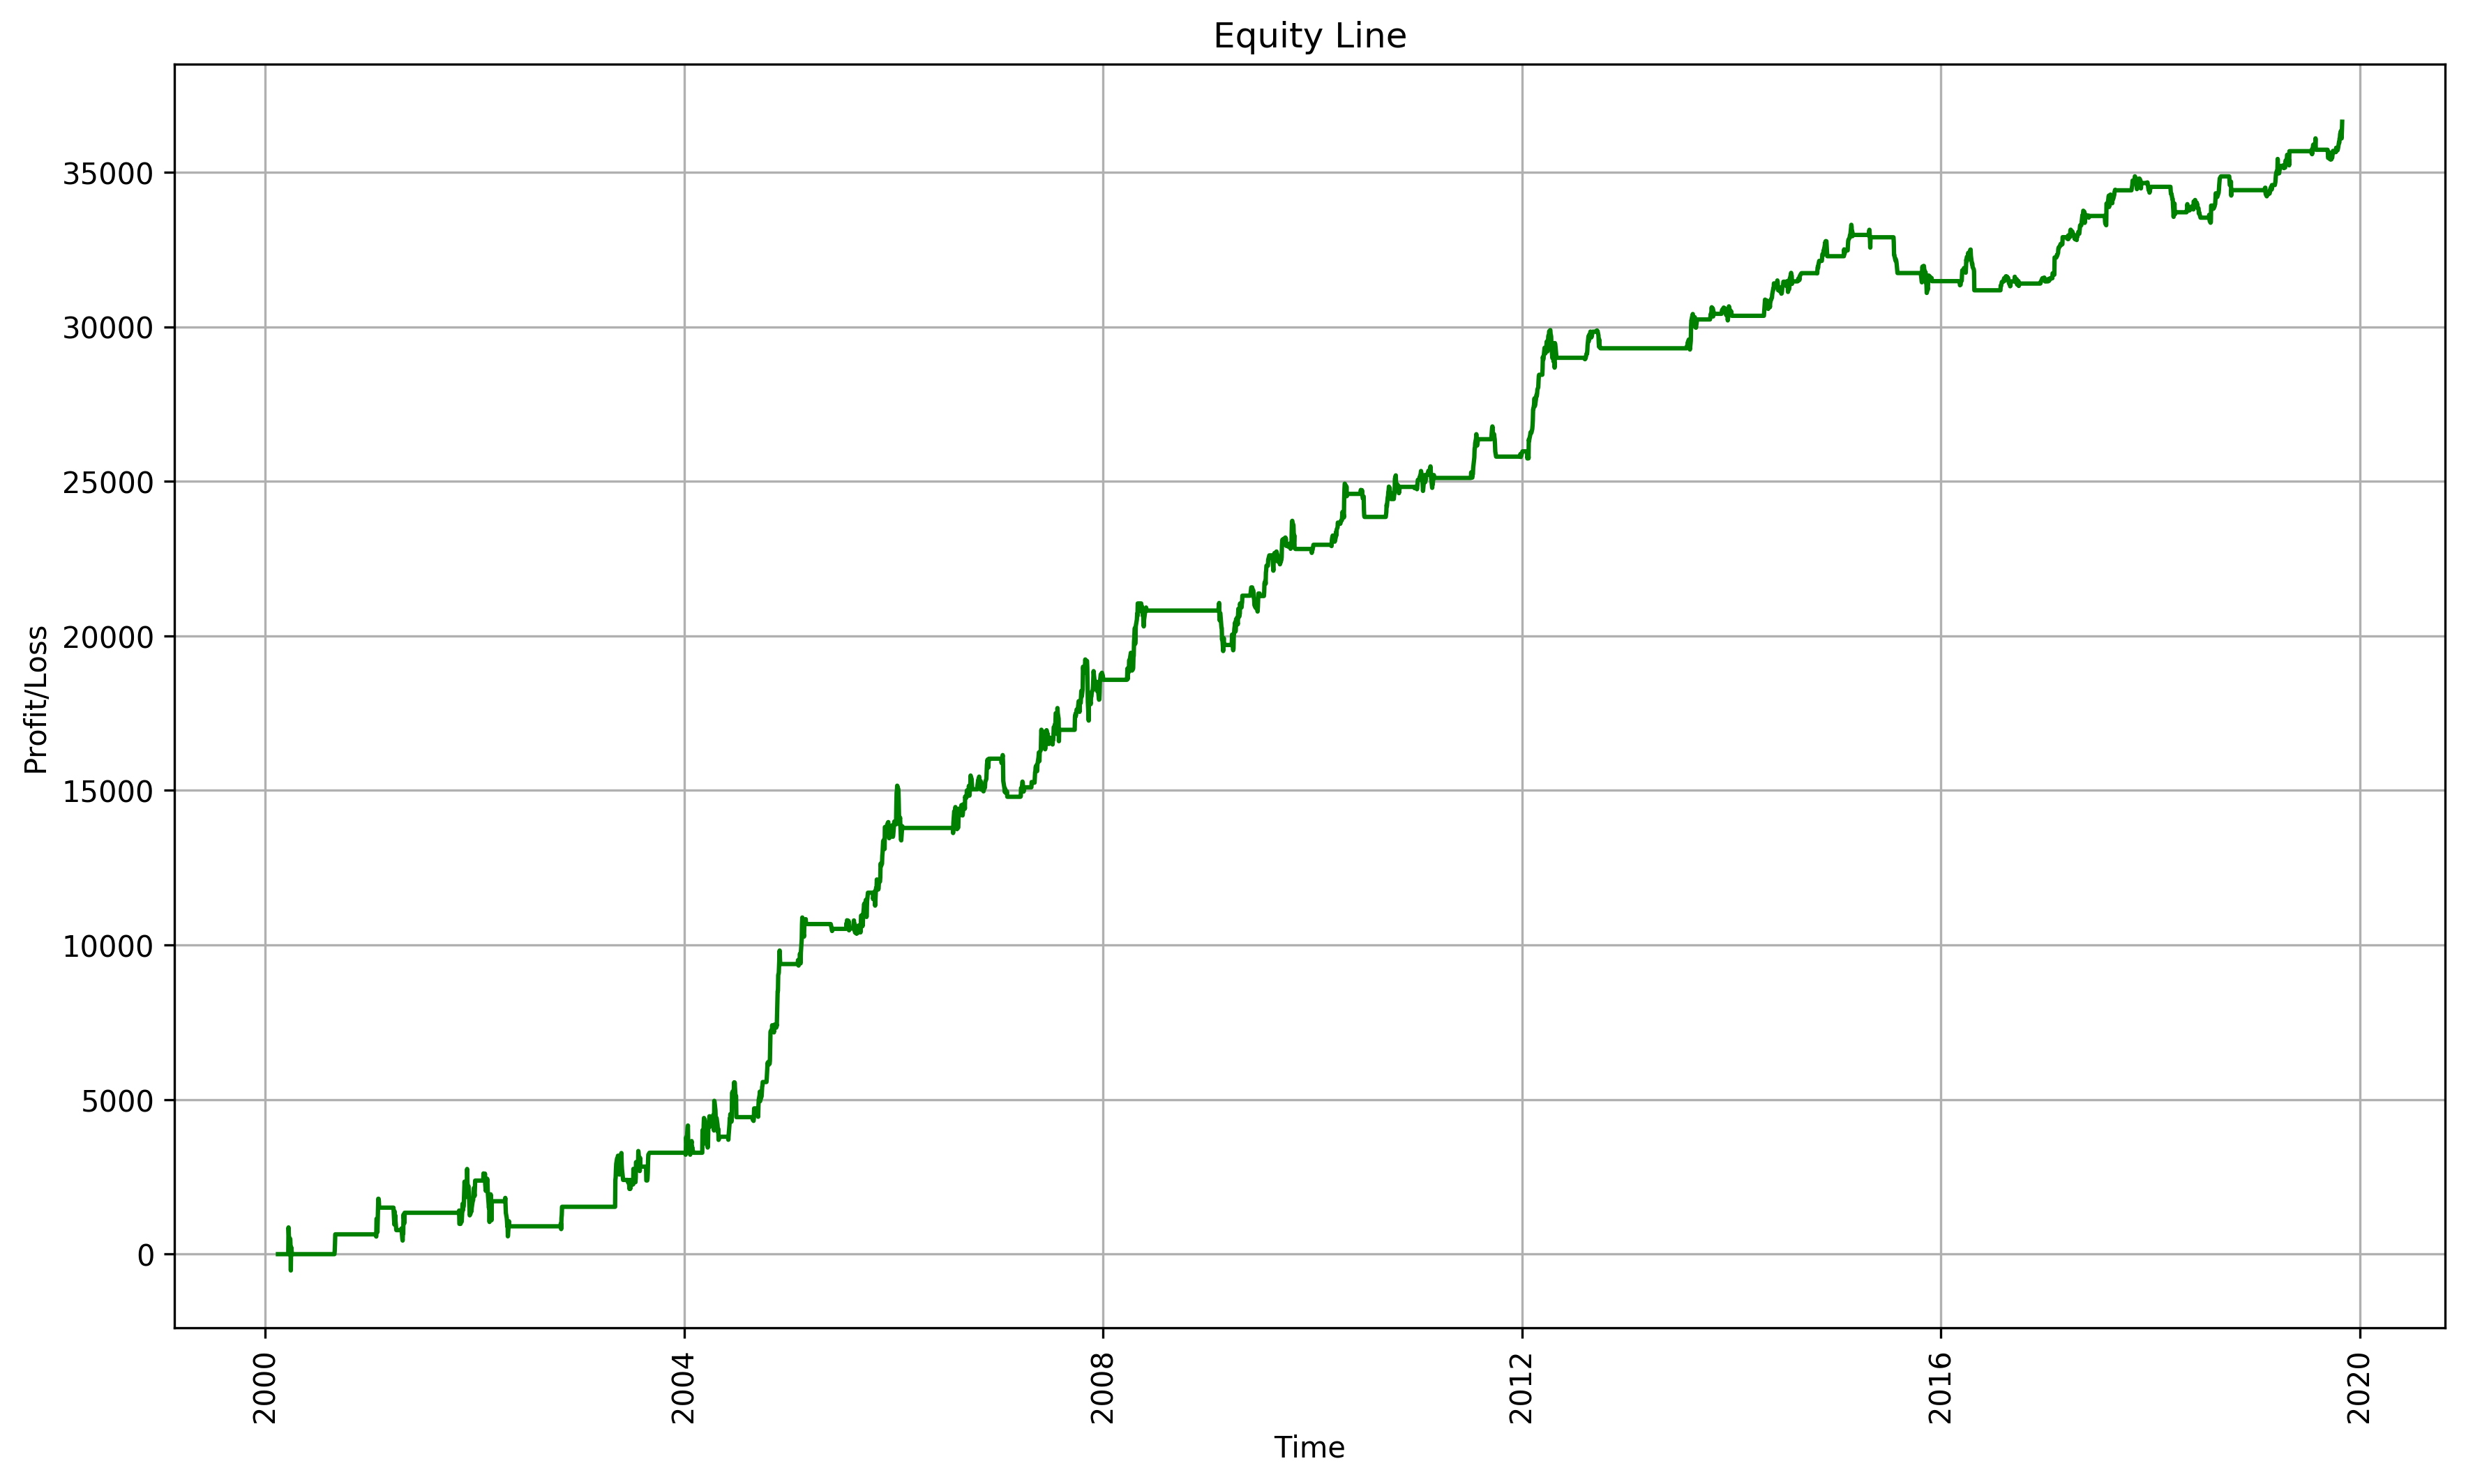

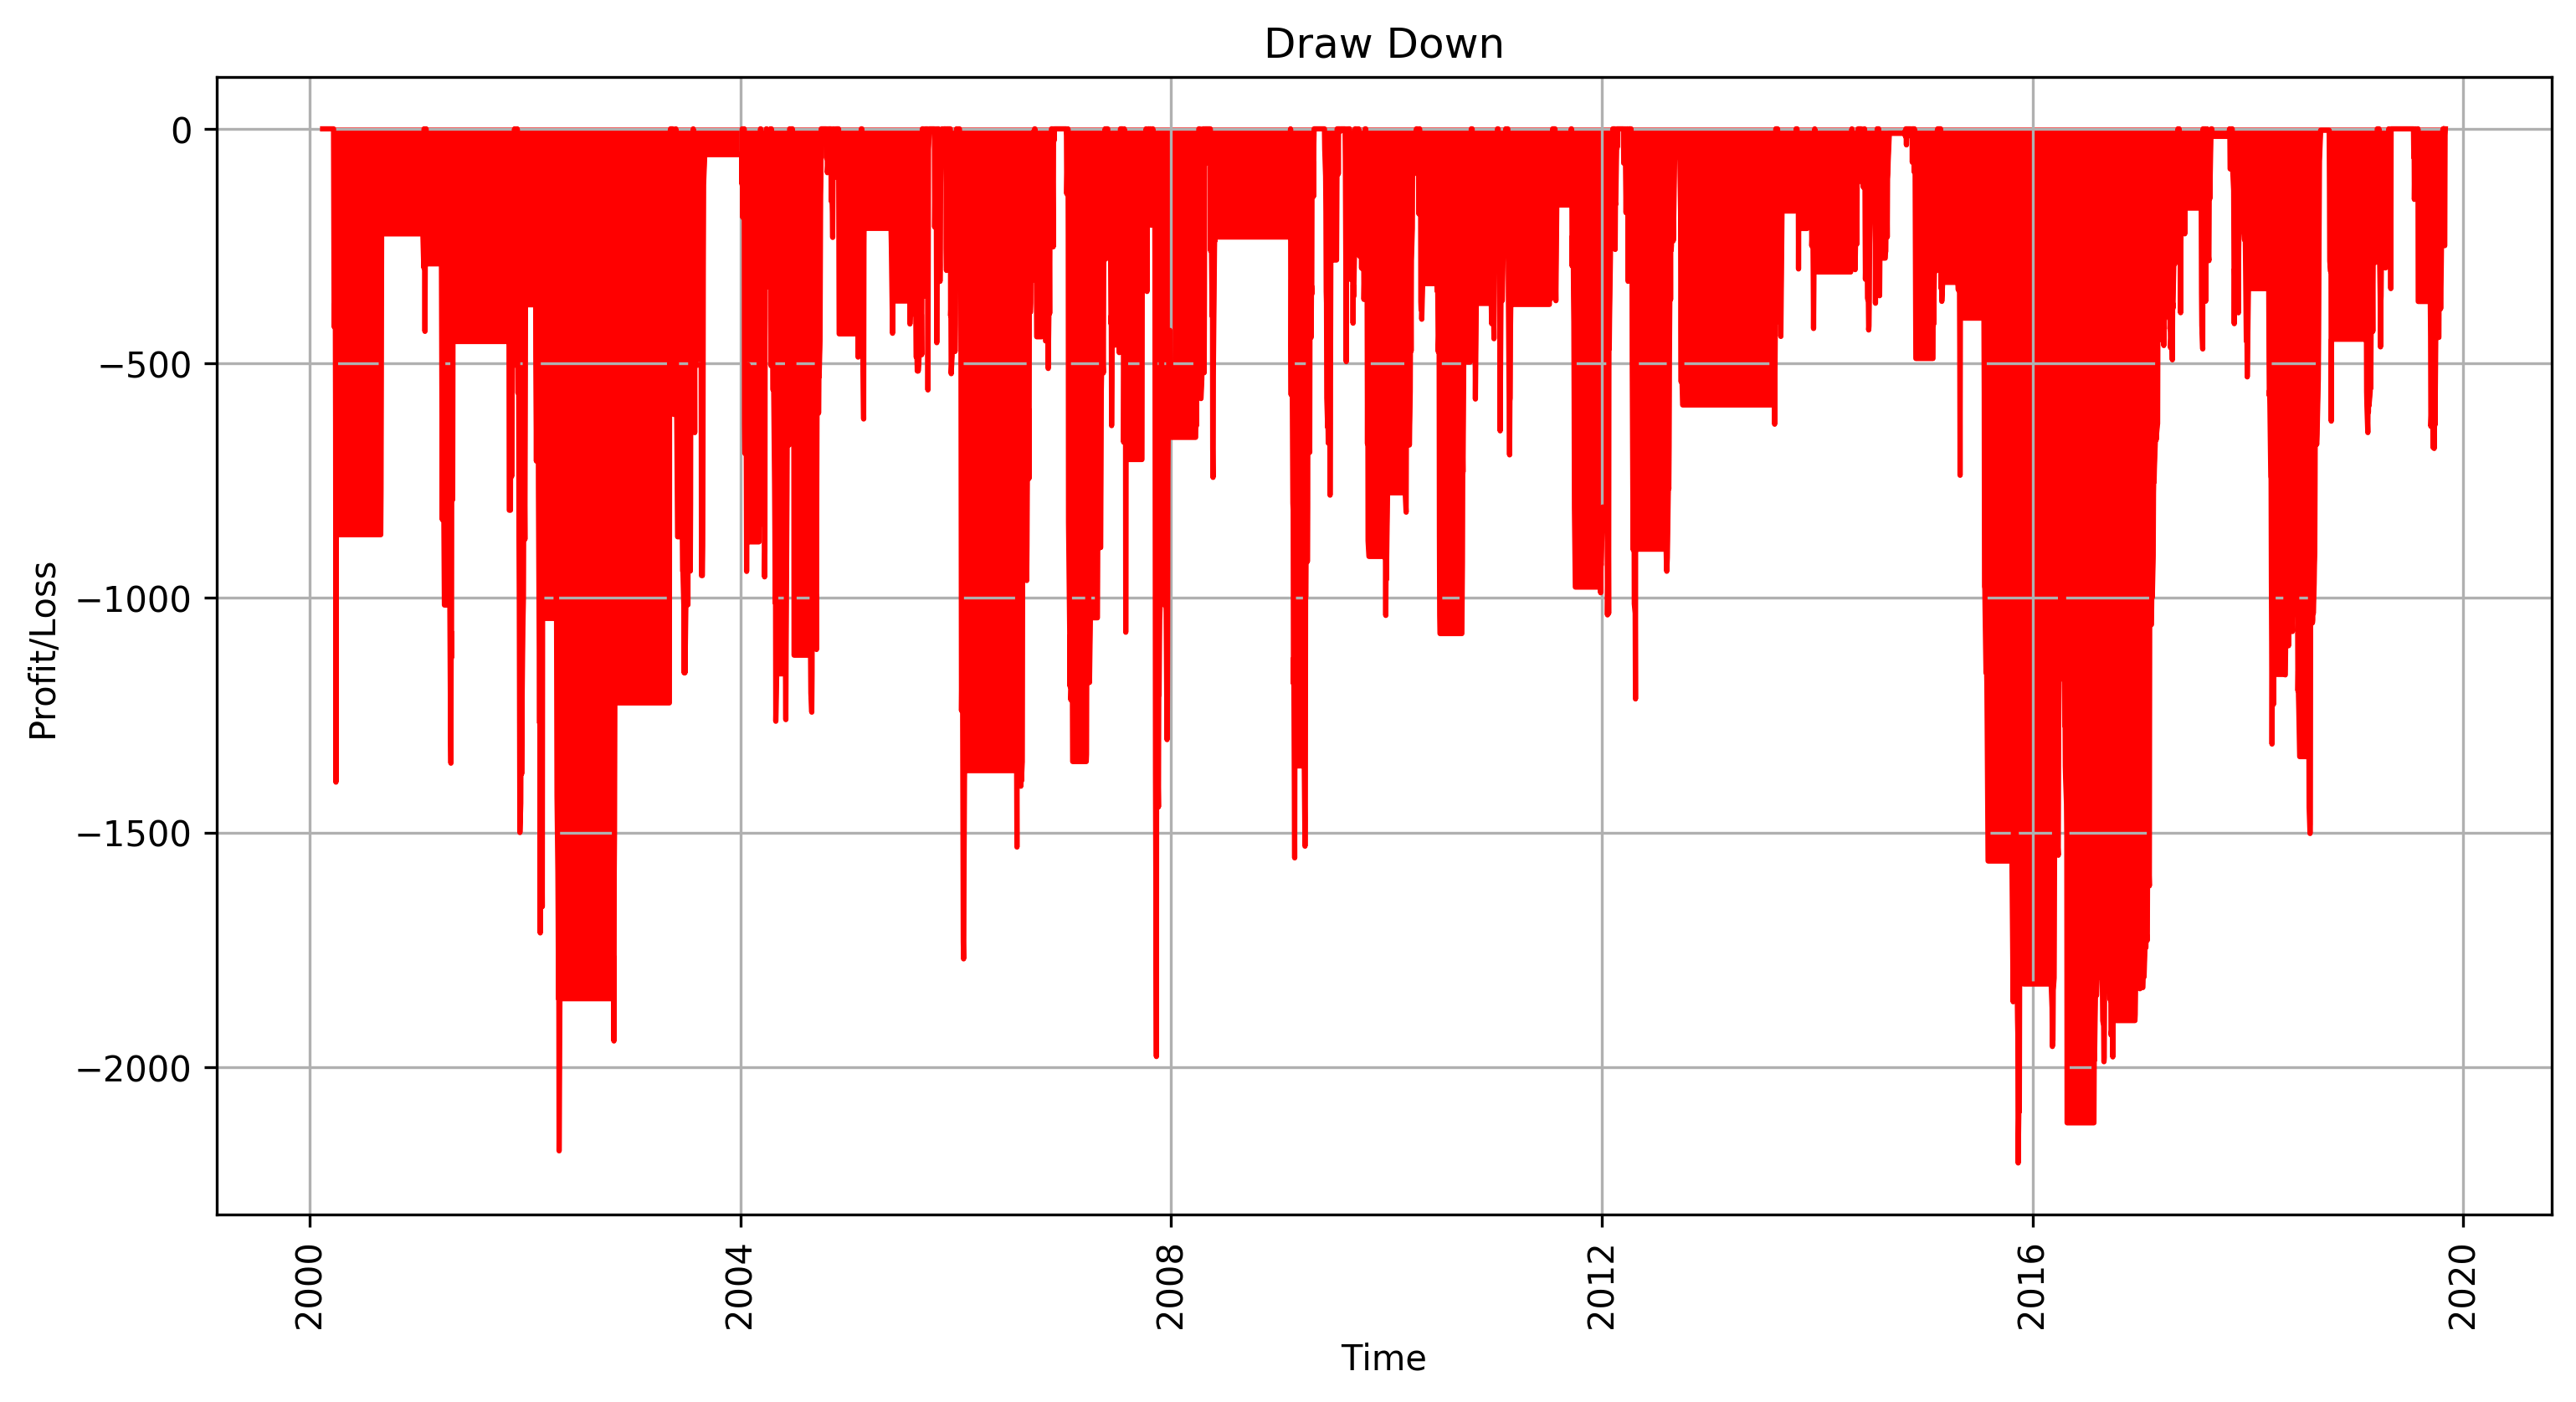

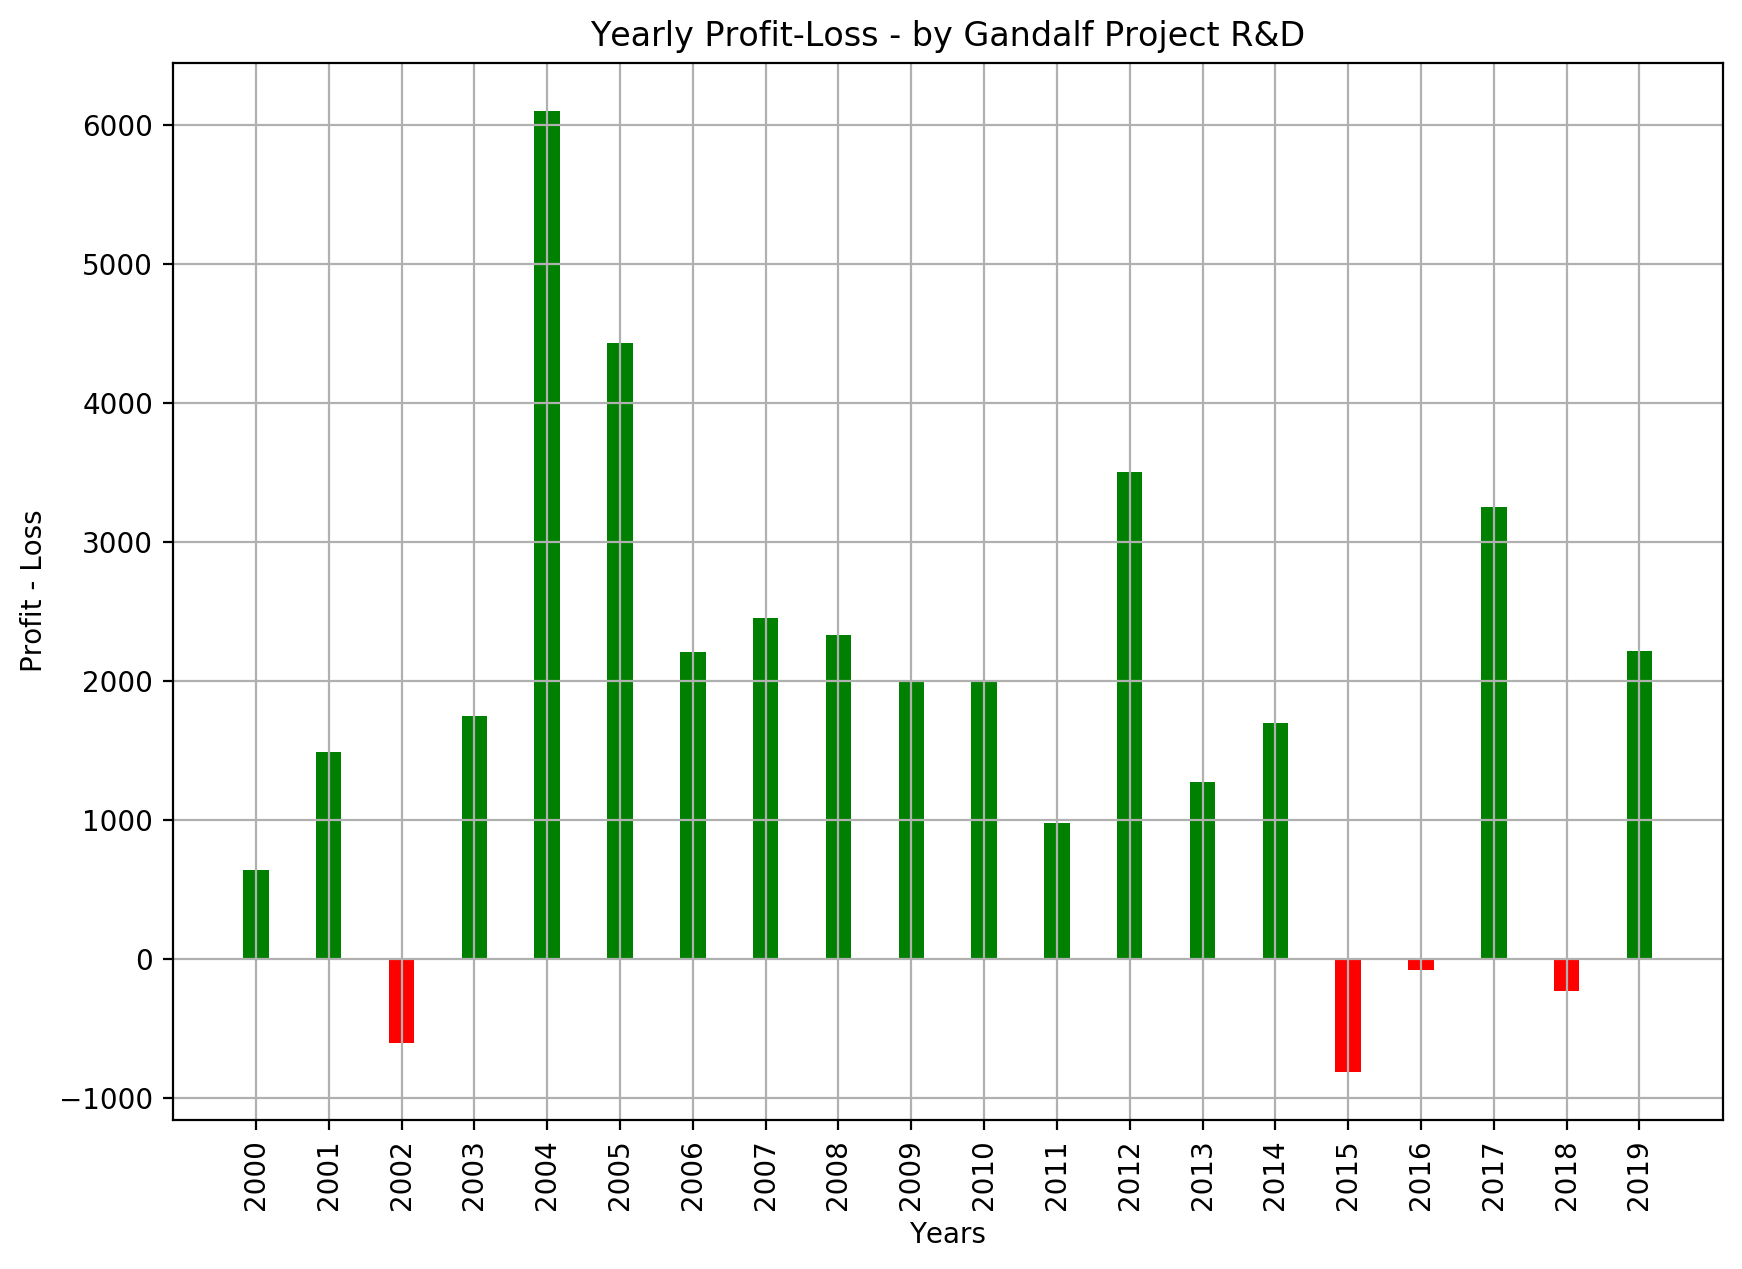

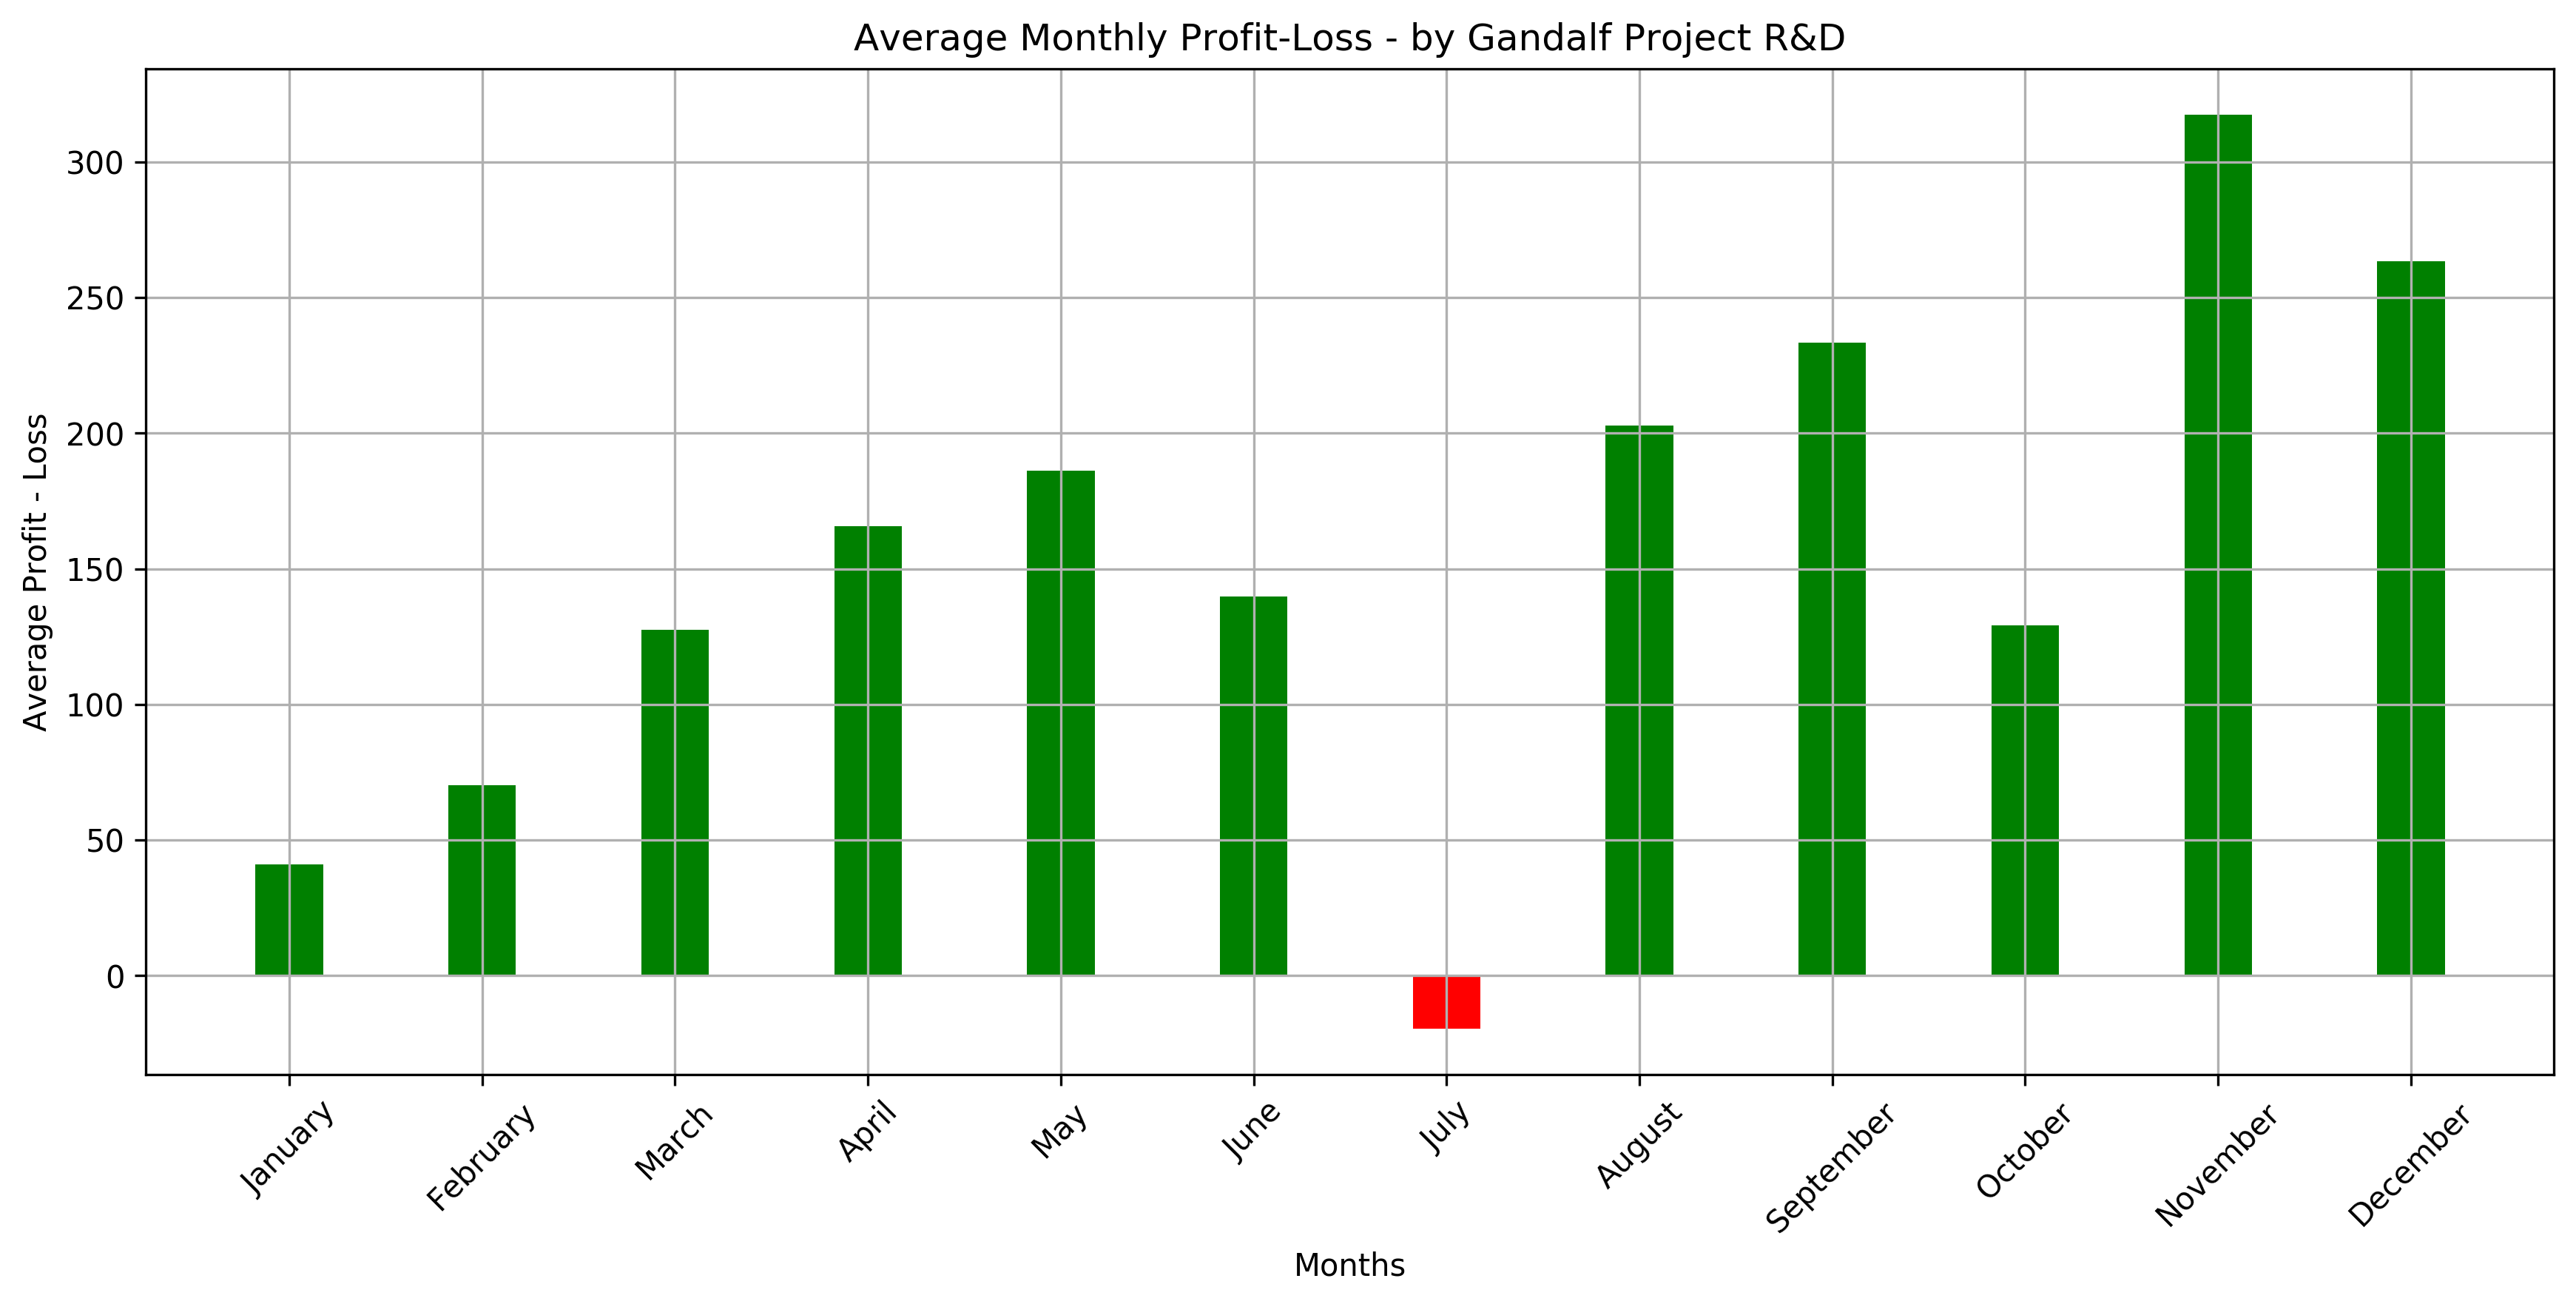

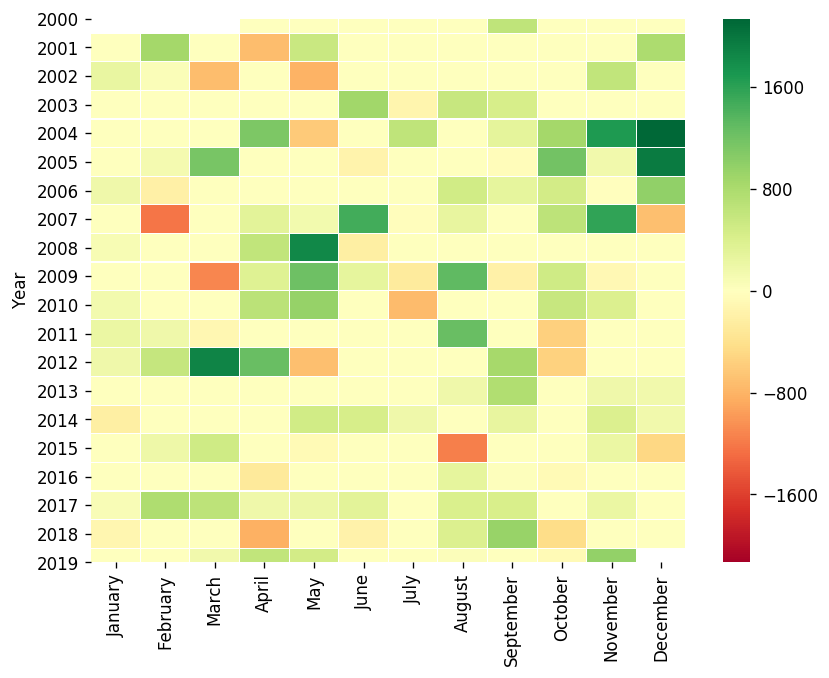

In [44]:
COSTS = 0
INSTRUMENT = 1 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.01
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "market"
enter_level = dataset.open

dataset = data.copy()

dataset["hhv"] = dataset.high.rolling(30).max()
dataset["llv"] = dataset.low.rolling(30).min()
dataset.dropna(inplace=True)

enter_rules = crossover(dataset.close,dataset.hhv.shift(1))

exit_rules = crossunder(dataset.close,dataset.llv.shift(1)) | (dataset.day < dataset.day.shift(1))

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system, operations,
                       trading_system.closed_equity, trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")